In [3]:
import pandas as pd
import numpy as np
import seaborn as sn
from matplotlib import pyplot as plt

importing the data, and looking at some information

In [4]:
har = pd.read_csv("DataSet_HAR.csv")
har.head()
har.describe()
har.isna().any()

tBodyAcc-mean()-X       False
tBodyAcc-mean()-Y       False
tBodyAcc-mean()-Z       False
tBodyAcc-std()-X        False
tBodyAcc-std()-Y        False
                        ...  
angle(X,gravityMean)    False
angle(Y,gravityMean)    False
angle(Z,gravityMean)    False
subject                 False
Activity                False
Length: 563, dtype: bool

In [5]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import accuracy_score

preprocessing

In [6]:
y = har["Activity"]
X = har.drop(["Activity", "subject"], axis = 1)
corr = X.corr()
le = LabelEncoder()
y = le.fit_transform(y)
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, test_size = 0.2, random_state = 0)

Taking a look at how certain features are correlated. No visualization though.

In [7]:
high_corr = {}
for col in corr.columns:
        for row in corr.columns:
                if corr[row][col] >= 0.9 or corr[row][col] <= -0.9:
                                if str(col + row) != str(row + col):
                                        high_corr[str(col)+ " " + str(row)]= corr[row][col]
                

Model fitting, training, and accuracy

In [8]:
lrmodel = LogisticRegression()
lrmodel.fit(Xtrain, ytrain)
lr_pred = lrmodel.predict(Xtest)
lr_conf = confusion_matrix(ytest, lr_pred)
lr_score = accuracy_score(ytest, lr_pred)

rfmodel = RandomForestClassifier(random_state = 0)
rfmodel.fit(Xtrain, ytrain)
rf_pred = rfmodel.predict(Xtest)
rf_score = accuracy_score(ytest, rf_pred)

C:\Users\cpak1\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


getting gini-importance from random forest

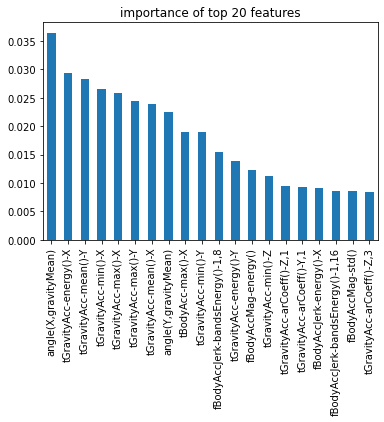

In [9]:
importances = {}
for col, importance in zip(X.columns, rfmodel.feature_importances_):
        importances[col] = importance
importances = pd.Series(importances)
importances.nlargest(20).plot.bar(x =  'feature names', y = 'gini-importance', title = 'importance of top 20 features')


some data visualization: there were too many features so I only took a few features

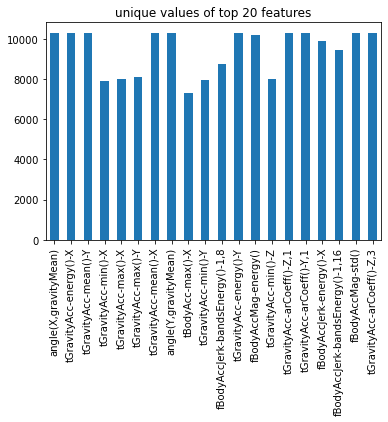

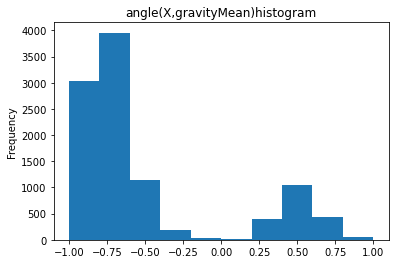

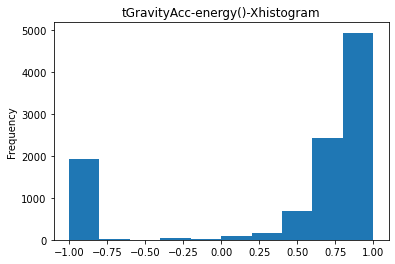

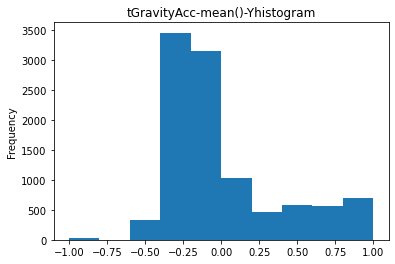

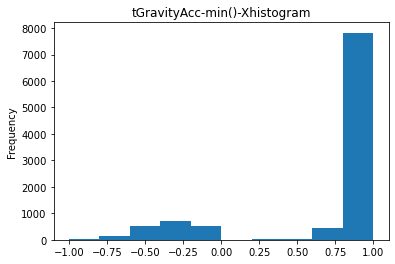

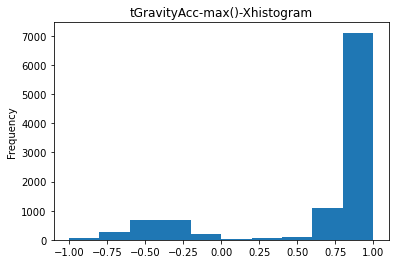

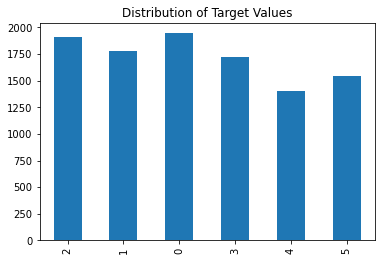

In [10]:
uniques = {}
for col in importances.nlargest(20).axes[0]:
        uniques[col] = len(X[col].unique())
uniques = pd.Series(uniques)
uniques.plot.bar(x = 'feature names', y = 'counts', title = 'unique values of top 20 features')

plt.figure()
for col in importances.nlargest(5).axes[0]:
        X[col].plot.hist(np.ceil(np.log2(len(X[col])))+1, title = (col + 'histogram'))
        plt.figure()
freq_y = {}
empty = []
for item in y:
        if item not in empty:
                freq_y[item] = 1
                empty.append(item)
        if item in empty:
                freq_y[item] += 1
pd.Series(freq_y).plot.bar(x = 'activity', y = 'counts', title = 'Distribution of Target Values')

function for selected random features, then returning said features

In [11]:
import random
def random_feat(data, num_feat = len(Xtrain.columns)):
        feats = data.columns
        selected = []
        while len(selected) < num_feat:
                choose = random.randint(0,num_feat)
                if feats[choose] not in selected:
                        selected.append(feats[choose])
        return selected

showing the true percentages for making a model on x features

In [ ]:
score = []
for i in range(1,len(X.columns)):
        selected = random_feat(Xtrain, i)
        Xtrain1 = Xtrain[selected]
        rfmodel = RandomForestClassifier()
        rfmodel.fit(Xtrain1, ytrain)
        rf_pred = rfmodel.predict(Xtest[selected])
        score.append(accuracy_score(ytest, rf_pred))
plt.plot(np.linspace(1,561, num=560 ), score)
plt.title("number of features v. accuracy")

Model scalability and performance viz

In [ ]:
from sklearn.model_selection import learning_curve
from sklearn.model_selection import ShuffleSplit
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):

    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt
cv= ShuffleSplit(n_splits=10, test_size=0.2,random_state=0)
plot_learning_curve(lrmodel, "Logistic Regression", X, y, cv=cv, n_jobs=4)


for i in range(1,len(X.columns)):
        selected = random_feat(Xtrain, i)
        Xtrain1 = Xtrain[selected]
        rfmodel = RandomForestClassifier()
        rfmodel.fit(Xtrain1, ytrain)
        rf_pred = rfmodel.predict(Xtest[selected])
        score.append(accuracy_score(ytest, rf_pred))
        print(i)
plt.plot(np.linspace(1,561, num=560 ), score)
plt.title("number of features v. accuracy")